# Lab 3 Solution: Implement GAN from Pseudocode (Goodfellow)

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# ----------------------------
# 1. Hyperparameters
# ----------------------------

In [2]:
latent_dim = 100
batch_size = 64
lr = 0.0002
beta1 = 0.5
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# ----------------------------
# 2. Load Data (MNIST)
# ----------------------------

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # scale to [-1, 1]
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.4MB/s]


# ----------------------------
# 3. Generator Model
# ----------------------------

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # output in [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

# ----------------------------
# 4. Discriminator Model
# ----------------------------

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid()  # probability [0,1]
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# ----------------------------
# 5. Initialize models & optimizers
# ----------------------------

In [6]:
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# ----------------------------
# 6. Training Discriminator and Generator Models simultaneously
# ----------------------------

In [7]:
os.makedirs("images", exist_ok=True)

In [8]:
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels: real=1, fake=0
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = G(z)

        real_pred = D(real_imgs)
        fake_pred = D(fake_imgs.detach())

        loss_real = criterion(real_pred, real_labels)
        loss_fake = criterion(fake_pred, fake_labels)
        loss_D = loss_real + loss_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = G(z)
        fake_pred = D(fake_imgs)

        # non-saturating loss (labels=1 for fake images)
        loss_G = criterion(fake_pred, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        # Logging
        # ---------------------
        if i % 200 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] "
                f"[Batch {i}/{len(dataloader)}] "
                f"[D loss: {loss_D.item():.4f}] "
                f"[G loss: {loss_G.item():.4f}]"
            )

    # Save sample images after each epoch
    z = torch.randn(25, latent_dim, device=device)
    sample_imgs = G(z).cpu().detach()
    sample_imgs = (sample_imgs + 1) / 2.0  # rescale to [0,1]

    grid = torch.cat([img for img in sample_imgs], dim=2)
    plt.imsave(f"images/epoch_{epoch}.png", grid.squeeze(), cmap="gray")

print("Training finished!")


[Epoch 0/50] [Batch 0/938] [D loss: 1.4056] [G loss: 0.7237]
[Epoch 0/50] [Batch 200/938] [D loss: 1.2382] [G loss: 0.9838]
[Epoch 0/50] [Batch 400/938] [D loss: 0.7576] [G loss: 1.1318]
[Epoch 0/50] [Batch 600/938] [D loss: 0.7798] [G loss: 1.3114]
[Epoch 0/50] [Batch 800/938] [D loss: 0.7550] [G loss: 1.6910]
[Epoch 1/50] [Batch 0/938] [D loss: 0.8686] [G loss: 1.2950]
[Epoch 1/50] [Batch 200/938] [D loss: 0.7680] [G loss: 1.5540]
[Epoch 1/50] [Batch 400/938] [D loss: 0.8224] [G loss: 1.8459]
[Epoch 1/50] [Batch 600/938] [D loss: 1.4332] [G loss: 2.7614]
[Epoch 1/50] [Batch 800/938] [D loss: 0.8744] [G loss: 1.5206]
[Epoch 2/50] [Batch 0/938] [D loss: 0.9414] [G loss: 0.9547]
[Epoch 2/50] [Batch 200/938] [D loss: 0.8706] [G loss: 1.3230]
[Epoch 2/50] [Batch 400/938] [D loss: 1.0613] [G loss: 2.7087]
[Epoch 2/50] [Batch 600/938] [D loss: 0.6719] [G loss: 1.9404]
[Epoch 2/50] [Batch 800/938] [D loss: 0.8137] [G loss: 2.2238]
[Epoch 3/50] [Batch 0/938] [D loss: 1.0145] [G loss: 0.9425]



# --- After training is finished ---
## Generate some images using the trained Generator


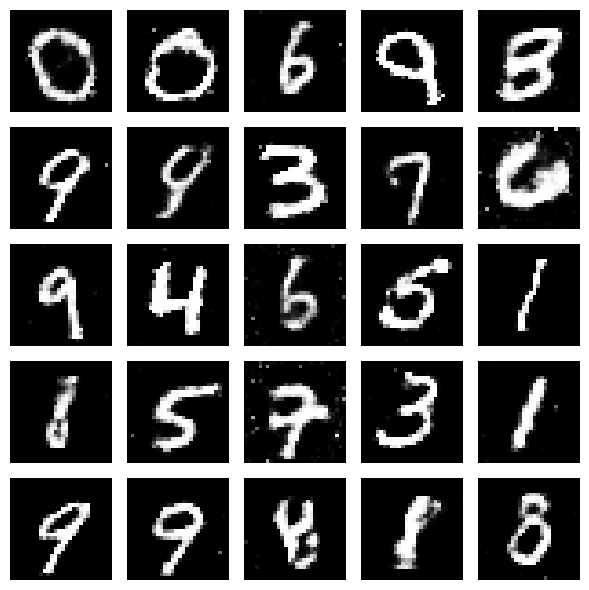

In [9]:
import torch
import matplotlib.pyplot as plt

# Put generator in evaluation mode
G.eval()

# Sample new latent vectors
n_samples = 25   # how many images you want
z = torch.randn(n_samples, latent_dim, device=device)

# Generate fake images
with torch.no_grad():
    gen_imgs = G(z).cpu()

# Rescale images from [-1,1] -> [0,1] for plotting
gen_imgs = (gen_imgs + 1) / 2.0

# --- Plot in grid ---
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()
